In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.ndimage as ndimage
from tqdm import tqdm_notebook
import community as cm
import networkx as nx
from collections import Counter
import pickle
from natsort import natsorted
from scipy.optimize import curve_fit

3015 5539


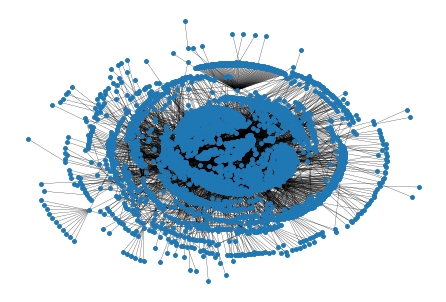

In [2]:
# g = nx.read_graphml('time_graphs/0/1750.graphml')
# g = nx.connected_watts_strogatz_graph(1500, 5, 0.15)
# g = nx.read_edgelist('real_graphs/facebook_combined.txt', data=False)
g = nx.read_graphml('0.graphml')
layout = nx.kamada_kawai_layout(g)

communities = nx.algorithms.community.centrality.girvan_newman(g)
print(g.number_of_nodes(), g.number_of_edges())
nx.draw(g, pos=layout, node_size=15, width=0.25)

In [3]:
levels = []
for com in tqdm_notebook(communities):
    levels.append(com)

In [5]:
cluster_nodes = []
for i in "abcdefghijklmnopqrstuvwxyz":
    for j in "abcdefghijklmnopqrstuvwxyz":
        for k in "abcdefghijklmnopqrstuvwxyz":
            cluster_nodes.append(i + j + k)
            
dendro = nx.DiGraph()
dendro.add_node(tuple(g.nodes))

In [6]:
levels = [[tuple(sorted(x)) for x in sub] for sub in levels]
dendro.add_nodes_from(levels[0])
dendro.add_edges_from([(tuple(g.nodes), l) for l in levels[0]])

In [7]:
for i in range(len(levels) - 1):
    dendro.add_nodes_from(levels[i])
    split = list(set(levels[i]) - set(levels[i]).intersection(set(levels[i+1])))
    children = list(set(levels[i+1]) - set(levels[i]).intersection(set(levels[i+1])))
    dendro.add_edges_from([(split[0], c) for c in children])

6029 6028


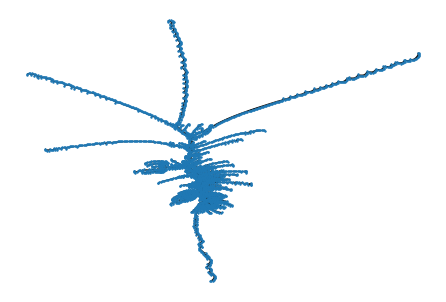

In [18]:
remap_dict = {}
counter = 0
draws = []
print(dendro.number_of_nodes(), dendro.number_of_edges())
for n in dendro.nodes:
    if len(n) > 1:
        remap_dict[n] = cluster_nodes[counter]
        counter += 1
    else:
        remap_dict[n] = n[0]
        draws.append(n[0])
        
remapped = nx.relabel_nodes(dendro, remap_dict)

nx.draw_kamada_kawai(nx.Graph(remapped), node_size=2, nodelist=draws)
plt.savefig('1500_dendro.png', dpi=4320)

[0.72309609]


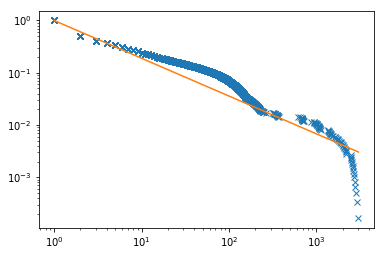

In [9]:
flattened = [x for y in levels for x in y]

flattened = list(set(flattened))

sizes = [len(x) for x in flattened]
sizes.append(g.number_of_nodes())

xs = sorted(sizes)
ys = [len([s for s in sizes if s >= m]) for m in xs]
ys = [y / len(sizes) for y in ys]

def hausdorff(lb, db):
    return lb**-db

popt = curve_fit(hausdorff, xs, ys)[0]
print(popt)

plt.xscale('log')
plt.yscale('log')
plt.plot(xs, ys, 'x')
curve_vals = [hausdorff(x, popt) for x in xs]
plt.plot(xs, curve_vals)

In [10]:
root = 'aaa'
nx.set_node_attributes(remapped, 0, 'hs')

# def compute_hs(node):
#     if not list(remapped.neighbors(node)):
#         remapped.node[node]['hs'] = 1
#     else:
#         children = list(remapped.neighbors(node))
#         if remapped.node[children[0]]['hs'] == 0:
#             compute_hs(children[0])
#         if remapped.node[children[1]]['hs'] == 0:
#             compute_hs(children[1])
#         if remapped.node[children[0]]['hs'] == remapped.node[children[1]]['hs']:
#             remapped.node[node]['hs'] = remapped.node[children[0]]['hs'] + 1
#         else:
#             remapped.node[node]['hs'] = max([remapped.node[children[0]]['hs'], remapped.node[children[1]]['hs']])
            
ratios = []
    
def compute_hs(node):
    if not list(remapped.neighbors(node)):
        ratios.append(1)
        return 1
    children = list(remapped.neighbors(node))
    if len(children) > 2:
        print(node, children)
        return
    l = children[0]
    r = children[1]
    
    if remapped.node[l]['hs'] == 0:
        remapped.node[l]['hs'] = compute_hs(l)
    if remapped.node[r]['hs'] == 0:
        remapped.node[r]['hs'] = compute_hs(r)
    
    if remapped.node[l]['hs'] == remapped.node[r]['hs']:
        ratios.append(remapped.node[r]['hs'] + 1)
        return remapped.node[r]['hs'] + 1
    return max([remapped.node[l]['hs'], remapped.node[r]['hs']])
            
remapped.node[root]['hs'] = compute_hs(root)
remapped.node[root]['hs']

7

In [11]:
Counter(nx.get_node_attributes(remapped, 'hs').values())

Counter({7: 16, 3: 564, 4: 121, 5: 48, 6: 36, 2: 2229, 1: 3015})

In [12]:
Counter(ratios)

Counter({1: 3015, 2: 527, 3: 147, 4: 41, 5: 6, 6: 2, 7: 1})

In [13]:
# vals = Counter(nx.get_node_attributes(remapped, 'hs').values())
vals = Counter(ratios)
bs = [vals[i+1] / vals[i+2] for i in range(len(vals) - 1)]
bs, sum(bs)/len(bs)

([5.721062618595825,
  3.5850340136054424,
  3.5853658536585367,
  6.833333333333333,
  3.0,
  2.0],
 4.120799303198856)

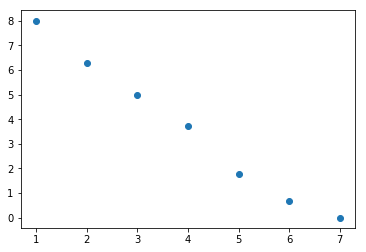

In [14]:
xs = list(Counter(ratios).values())
xs = [np.log(x) for x in xs]

plt.scatter(np.arange(1, len(xs) + 1), xs)

[915.0625, 166.375, 30.25, 5.5, 1.0, 0.18181818181818182, 0.03305785123966942]
[3015, 527, 147, 41, 6, 2, 1]


[]

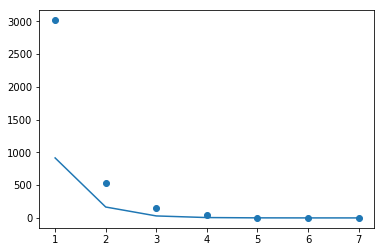

In [15]:
xs = list(Counter(ratios).values())
# xs = [np.log(x) for x in xs]

x2 = np.arange(1, len(vals) + 1)
y2 = [5.5** (5 - x) for x in x2]
print(y2)
print(xs)
# y2 = [v / 5.87 for v in reversed(sorted(vals.values()))]
# y2 = [np.log(y) for y in y2]

plt.scatter(np.arange(1, len(xs) + 1), xs)
plt.plot(x2, y2)
plt.plot()

[ 7.38993181 41.41452986]


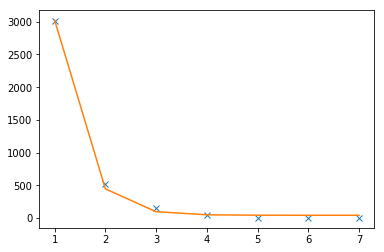

In [16]:
y3 = [np.log(x) for x in xs]
y3 = xs
x3 = np.arange(1, len(vals) + 1)

def hausdorff(x, b, a):
    return a + b ** (5-x)

popt = curve_fit(hausdorff, x3, y3)[0]
print(popt)

# plt.xscale('log')
# plt.yscale('log')
plt.plot(x3, y3, 'x')
curve_vals = [hausdorff(x, *popt) for x in x3]
plt.plot(x3, curve_vals)

In [17]:
pickle.dump(levels, open('AS.pkl', 'wb'))